In [49]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

import sklearn
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold
from sklearn import metrics 
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from pylab import rcParams
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC
from scipy.stats import uniform as sp_uniform
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
import seaborn as sb

# 1. Multinomial logistic regression and cross validation

In [2]:
drink = pd.read_csv('strongdrink.txt')
drink.sample(5)

,cultivar,alco,malic,ash,alk,magn,tot_phen,flav,nonfl_phen,proanth,color_int,hue,OD280rat,proline
74,2,11.96,1.09,2.30,21.0,101,3.38,2.14,0.13,1.65,3.21,0.99,3.13,886
88,2,11.64,2.06,2.46,21.6,84,1.95,1.69,0.48,1.35,2.80,1.00,2.75,680
102,2,12.34,2.45,2.46,21.0,98,2.56,2.11,0.34,1.31,2.80,0.80,3.38,438
114,2,12.08,1.39,2.50,22.5,84,2.56,2.29,0.43,1.04,2.90,0.93,3.19,385
150,3,12.79,2.67,2.48,22.0,112,1.48,1.36,0.24,1.26,10.80,0.48,1.47,480


In [3]:
X = drink[['alco', 'malic', 'tot_phen', 'color_int']].values
y = drink['cultivar'].values

### a) 75% training set

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,random_state=20)
clf = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial').fit(X_train, y_train)

parameters = pd.DataFrame({"j=1":np.append(clf.intercept_[0],clf.coef_[0]),
                           "j=2":np.append(clf.intercept_[1],clf.coef_[1])},
                          index=["β0","β1",'β2','β3','β4'])

parameters

,j=1,j=2
β0,-24.027617,22.780733
β1,1.701734,-1.466297
β2,-0.265788,-0.332951
β3,1.224101,0.663556
β4,0.022507,-0.922682


In [5]:
y_pred=clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.87      1.00      0.93        13
           2       1.00      0.90      0.95        21
           3       1.00      1.00      1.00        10

    accuracy                           0.95        44
   macro avg       0.96      0.97      0.96        44
weighted avg       0.96      0.95      0.96        44



In [6]:
drink['cultivar'].value_counts()

2    71
1    59
3    46
Name: cultivar, dtype: int64

In [7]:
print(mean_squared_error(y_test, y_pred))

0.045454545454545456


- Error rates for j=1 is 13%, j=2 is 0%.
- category 2 is best predicted as category 3 is the baseline class.
- The most accurately predicdted category is not the one with the most observations.
- MSE is 0.04545.

### b) leave-one-out cross validation

In [8]:
N_loo = X.shape[0]
loo = LeaveOneOut()
loo.get_n_splits(X)
MSE_vec = np.zeros(N_loo)
y_test_vec = np.zeros(N_loo)
y_pred_vec = np.zeros(N_loo)

In [9]:
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    LogReg = LogisticRegression(solver = 'liblinear', multi_class='auto')
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    MSE_vec[test_index] = (y_test - y_pred) ** 2
#     print('MSE for test set', test_index, ' is', MSE_vec[test_index])
    y_test_vec[test_index] = y_test
    y_pred_vec[test_index] = y_pred

print(classification_report(y_test_vec, y_pred_vec))

              precision    recall  f1-score   support

         1.0       0.84      0.78      0.81        59
         2.0       0.83      0.89      0.86        71
         3.0       0.96      0.93      0.95        46

    accuracy                           0.86       176
   macro avg       0.87      0.87      0.87       176
weighted avg       0.86      0.86      0.86       176



Error rates is 16% for j=1, 17% for j = 0, 4% for j = 3, much worse than the 75% train test split.

In [10]:
MSE_loo = MSE_vec.mean()
print('LOOCV MSE =', MSE_loo)

LOOCV MSE = 0.1875


### c) k-fold cross validation

In [11]:
k = 4
kf = KFold(n_splits = k, shuffle = True, random_state = 10)
kf.get_n_splits(X)
N_loo = X.shape[0]
MSE_vec_kf = np.zeros(k)
y_test_vec_kf = np.zeros(N_loo)
y_pred_vec_kf = np.zeros(N_loo)

In [12]:
k_ind = int(0)
for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     print('k index=', k_ind)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    Mlogit = LogisticRegression(random_state=0, solver='newton-cg', multi_class='multinomial')
    Mlogit.fit(X_train, y_train)
    y_pred = Mlogit.predict(X_test)

    MSE_vec_kf[k_ind] = mean_squared_error(y_test, y_pred)
    y_test_vec_kf[test_index] = y_test
    y_pred_vec_kf[test_index] = y_pred
    print('MSE for test set', k_ind, 'is', MSE_vec_kf[k_ind])
    k_ind += 1
    
print(classification_report(y_test_vec_kf, y_pred_vec_kf))

MSE for test set 0 is 0.22727272727272727
MSE for test set 1 is 0.11363636363636363
MSE for test set 2 is 0.045454545454545456
MSE for test set 3 is 0.045454545454545456
              precision    recall  f1-score   support

         1.0       0.87      0.93      0.90        59
         2.0       0.91      0.87      0.89        71
         3.0       0.96      0.93      0.95        46

    accuracy                           0.91       176
   macro avg       0.91      0.91      0.91       176
weighted avg       0.91      0.91      0.91       176



Error rate is 13% for j=1, 9% for j=2, 4% for j=3, worse than the 75% train test split but better than LOOCV

In [13]:
MSE_kf = MSE_vec_kf.mean()
print('K-fold MSE =', MSE_kf)

K-fold MSE = 0.10795454545454546


# 2. Decision trees

In [14]:
biden = pd.read_csv('biden.csv')
biden.sample(5)

,biden,female,age,educ,dem,rep
91,50,1,20,12,0,0
1738,85,1,83,13,1,0
1098,50,1,60,14,1,0
1617,70,1,69,17,1,0
839,85,0,50,12,1,0


In [15]:
X = biden[['female', 'age', 'educ', 'dem', 'rep']].values
y = biden['biden'].values

### a) 70% training set

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=20)

biden_tree = DecisionTreeRegressor(max_depth=3, min_samples_leaf=5)
biden_tree.fit(X_train, y_train)
y_pred = biden_tree.predict(X_test)
print('70% training set MSE =', mean_squared_error(y_test, y_pred))

70% training set MSE = 386.8938634284023


### b) Tune hyperparameters

In [17]:
param_dist1 = {'max_depth': [3, 10],
               'min_samples_split': sp_randint(2, 20),
               'min_samples_leaf': sp_randint(2, 20)}

random_search = \
    RandomizedSearchCV(biden_tree, param_distributions=param_dist1,
                       n_iter=100, n_jobs=-1, cv=5, random_state=20,
                       scoring='neg_mean_squared_error')

random_search.fit(X, y)  
print('Random Best Estimator =', random_search.best_estimator_)
print('Random Best Params (Optimal Tuning Parameter Values) =', random_search.best_params_)
print('Random Best Score (MSE) =', -random_search.best_score_)

Random Best Estimator = DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=18,
                      min_samples_split=11, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')
Random Best Params (Optimal Tuning Parameter Values) = {'max_depth': 3, 'min_samples_leaf': 18, 'min_samples_split': 11}
Random Best Score (MSE) = 401.6903602232667


### c) Tune hyperparameters for random forest

In [18]:
biden_RF = RandomForestRegressor(random_state = 20)

param_dist2 = {'n_estimators': [10, 200],
               'max_depth': [3, 10],
               'min_samples_split': sp_randint(2, 20),
               'min_samples_leaf': sp_randint(2, 20),
               'max_features': sp_randint(1, 5)}

random_search_RF = \
    RandomizedSearchCV(biden_RF, param_distributions=param_dist2,
                       n_iter=100, n_jobs=-1, cv=5, random_state=20,
                       scoring='neg_mean_squared_error')

random_search_RF.fit(X, y)  
print('Random Best Estimator =', random_search_RF.best_estimator_)
print('Random Best Params (Optimal Tuning Parameter Values) =', random_search_RF.best_params_)
print('Random Best Score (MSE) =', -random_search_RF.best_score_)

Random Best Estimator = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
                      max_features=3, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=18, min_samples_split=16,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=20, verbose=0,
                      warm_start=False)
Random Best Params (Optimal Tuning Parameter Values) = {'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 18, 'min_samples_split': 16, 'n_estimators': 200}
Random Best Score (MSE) = 397.4387994329025


# 3. Classifier "horse" race

In [19]:
auto = pd.read_csv('auto.csv', na_values='?')
auto.sample(5)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
43,13.0,8,400.0,170.0,4746,12.0,71,1,ford country squire (sw)
293,31.9,4,89.0,71.0,1925,14.0,79,2,vw rabbit custom
160,17.0,6,231.0,110.0,3907,21.0,75,1,buick century
152,19.0,6,225.0,95.0,3264,16.0,75,1,plymouth valiant custom
266,30.0,4,98.0,68.0,2155,16.5,78,1,chevrolet chevette


In [20]:
auto['mpg'].median()

23.0

In [21]:
auto['mpg_high'] = np.where(auto['mpg'] >= auto['mpg'].median(), 1, 0)
auto["orgn1"] = np.where(auto["origin"] == 1, 1, 0)
auto["orgn2"] = np.where(auto["origin"] == 2, 1, 0)
auto['const'] = 1
auto.dropna(inplace = True)
auto.sample(5)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,mpg_high,orgn1,orgn2,const
142,26.0,4,79.0,67.0,1963,15.5,74,2,volkswagen dasher,1,0,1,1
152,19.0,6,225.0,95.0,3264,16.0,75,1,plymouth valiant custom,0,1,0,1
199,20.0,6,225.0,100.0,3651,17.7,76,1,dodge aspen se,0,1,0,1
116,16.0,8,400.0,230.0,4278,9.5,73,1,pontiac grand prix,0,1,0,1
346,32.3,4,97.0,67.0,2065,17.8,81,3,subaru,1,0,0,1


### a) K-fold logistic regression

In [22]:
X = auto[['const', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'orgn1', 'orgn2']].values.astype(float)
y = auto['mpg_high'].values.astype(float)

In [23]:
k = 4
kf_log = KFold(n_splits=k, shuffle=True, random_state=25)
kf_log.get_n_splits(X)
N_loo = X.shape[0]
MSE_vec_kf = np.zeros(k)
y_test_vec_kf = np.zeros(N_loo)
y_pred_vec_kf = np.zeros(N_loo)

In [24]:
k_ind = int(0)
for train_index, test_index in kf_log.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     print('k index=', k_ind)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    Mlogit = LogisticRegression(random_state=0, solver='newton-cg', multi_class='multinomial')
    Mlogit.fit(X_train, y_train)
    y_pred = Mlogit.predict(X_test)

    MSE_vec_kf[k_ind] = mean_squared_error(y_test, y_pred)
    y_test_vec_kf[test_index] = y_test
    y_pred_vec_kf[test_index] = y_pred
    print('MSE for test set', k_ind, 'is', MSE_vec_kf[k_ind])
    k_ind += 1
    
print(classification_report(y_test_vec_kf, y_pred_vec_kf))
print('MSE =', MSE_vec_kf.mean())

MSE for test set 0 is 0.1326530612244898
MSE for test set 1 is 0.08163265306122448


/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


MSE for test set 2 is 0.07142857142857142
MSE for test set 3 is 0.07142857142857142
              precision    recall  f1-score   support

         0.0       0.94      0.88      0.91       196
         1.0       0.89      0.94      0.91       196

    accuracy                           0.91       392
   macro avg       0.91      0.91      0.91       392
weighted avg       0.91      0.91      0.91       392

MSE = 0.08928571428571427


Error rate for mpg_high = 1 is 0.11, for mpg_high = 0 is 0.06

### b) Random Forest Classifier

In [25]:
auto_RF = RandomForestRegressor(random_state = 25)

param_dist = {'n_estimators': [10, 200],
               'max_depth': [3, 8],
               'min_samples_split': sp_randint(2, 20),
               'min_samples_leaf': sp_randint(2, 20),
               'max_features': sp_randint(1, 8)}

random_search_RF = \
    RandomizedSearchCV(auto_RF, param_distributions=param_dist,
                       n_iter=100, n_jobs=-1, cv=4, random_state=25,
                       scoring='neg_mean_squared_error')

random_search_RF.fit(X, y)  
print('Random Best Estimator =', random_search_RF.best_estimator_)
print('Random Best Params (Optimal Tuning Parameter Values) =', random_search_RF.best_params_)
print('Random Best Score (MSE) =', -random_search_RF.best_score_)

Random Best Estimator = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
                      max_features=1, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=7,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=25, verbose=0,
                      warm_start=False)
Random Best Params (Optimal Tuning Parameter Values) = {'max_depth': 3, 'max_features': 1, 'min_samples_leaf': 5, 'min_samples_split': 7, 'n_estimators': 10}
Random Best Score (MSE) = 0.09445434608069206


### c) SVC with tuning hyperparameter

In [26]:
auto_SVC = SVC(kernel = 'rbf')

param_dist4 = {'C': sp_uniform(loc=0.2, scale=4.0),
               'gamma': ['scale', 'auto'],
               'shrinking': [True, False]}

random_search_SVC = \
    RandomizedSearchCV(auto_SVC, param_distributions=param_dist4,
                       n_iter=100, n_jobs=-1, cv=4, random_state=25,
                       scoring='neg_mean_squared_error')

random_search_SVC.fit(X, y)  
print('Random Best Estimator =', random_search_SVC.best_estimator_)
print('Random Best Params (Optimal Tuning Parameter Values) =', random_search_SVC.best_params_)
print('Random Best Score (MSE) =', -random_search_SVC.best_score_)

Random Best Estimator = SVC(C=0.3377990724342859, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=False,
    tol=0.001, verbose=False)
Random Best Params (Optimal Tuning Parameter Values) = {'C': 0.3377990724342859, 'gamma': 'scale', 'shrinking': False}
Random Best Score (MSE) = 0.11734693877551021


Based on MSE, the best model is 4-fold logistic regression.

# 4. Neural network horse race

In [27]:
drink.sample(5)

,cultivar,alco,malic,ash,alk,magn,tot_phen,flav,nonfl_phen,proanth,color_int,hue,OD280rat,proline
30,1,13.73,1.50,2.70,22.5,101,3.00,3.25,0.29,2.38,5.70,1.19,2.71,1285
146,3,12.87,4.61,2.48,21.5,86,1.70,0.65,0.47,0.86,7.65,0.54,1.86,625
104,2,12.51,1.73,1.98,20.5,85,2.20,1.92,0.32,1.48,2.94,1.04,3.57,672
136,3,12.53,5.51,2.64,25.0,96,1.79,0.60,0.63,1.10,5.00,0.82,1.69,515
93,2,12.29,2.83,2.22,18.0,88,2.45,2.25,0.25,1.99,2.15,1.15,3.30,290


### a) scatter plot

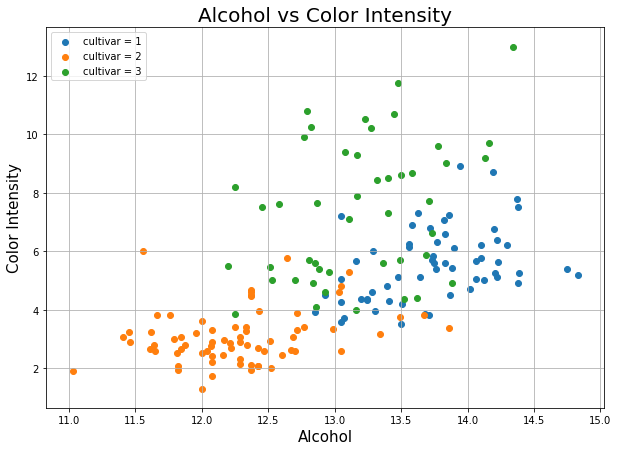

In [28]:
plt.subplots(1,1, figsize = (10,7))
for i in [1,2,3]:
    data = drink[drink['cultivar'] == i]
    plt.scatter(data['alco'], data['color_int'], label = 'cultivar = {}'.format(i))
    
plt.xlabel('Alcohol', fontsize = 15)
plt.ylabel('Color Intensity', fontsize = 15)
plt.title('Alcohol vs Color Intensity', fontsize = 20)
plt.legend()
plt.grid()
plt.show()

### b) Logistic regression

In [29]:
X = drink[['alco', 'malic', 'tot_phen', 'color_int']].values
y = drink['cultivar'].values

In [42]:
drink_log = LogisticRegression(solver = 'liblinear', multi_class = 'auto', random_state = 25)

param_dist_log = {'penalty': ['l1', 'l2'], 
                  'C': sp_uniform(0.1, 10.0)}

random_search_log = RandomizedSearchCV(drink_log, param_dist_log, iid = True,
                                       n_iter = 200, n_jobs = -1, cv = 5,
                                       random_state = 25, scoring = 'neg_mean_squared_error')

random_search_log.fit(X, y)
print('Random Best Logistic Estimator =', random_search_log.best_estimator_)
print('Random Best Logistic Params (Optimal Tuning Parameter Values) =', random_search_log.best_params_)
print('Random Best Logistic Score (MSE) =', -random_search_log.best_score_)

Random Best Logistic Estimator = LogisticRegression(C=2.665871587495725, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=25, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
Random Best Logistic Params (Optimal Tuning Parameter Values) = {'C': 2.665871587495725, 'penalty': 'l1'}
Random Best Logistic Score (MSE) = 0.11931818181818182


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### c) Random Forest

In [46]:
drink_RF = RandomForestClassifier(random_state = 25)

param_dist_RF = {'n_estimators': sp_randint(10, 200),
                 'max_depth': sp_randint(2, 4),
                 'min_samples_split': sp_randint(2, 20),
                 'min_samples_leaf': sp_randint(2, 20),
                 'max_features': sp_randint(1, 4)}

random_search_RF = RandomizedSearchCV(drink_RF, param_dist_RF, iid = True,
                                       n_iter = 200, n_jobs = -1, cv = 5,
                                       random_state = 25, scoring = 'neg_mean_squared_error')

random_search_RF.fit(X, y)
print('Random Best RF Estimator =', random_search_RF.best_estimator_)
print('Random Best RF Params (Optimal Tuning Parameter Values) =', random_search_RF.best_params_)
print('Random Best RF Score (MSE) =', -random_search_RF.best_score_)

Random Best RF Estimator = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features=1, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=13, min_samples_split=18,
                       min_weight_fraction_leaf=0.0, n_estimators=176,
                       n_jobs=None, oob_score=False, random_state=25, verbose=0,
                       warm_start=False)
Random Best RF Params (Optimal Tuning Parameter Values) = {'max_depth': 3, 'max_features': 1, 'min_samples_leaf': 13, 'min_samples_split': 18, 'n_estimators': 176}
Random Best RF Score (MSE) = 0.13068181818181818


### d) SVC

In [48]:
drink_SVC = SVC(random_state = 25)

param_dist_SVC = {'C': sp_uniform(loc=0.1, scale=10.0),
                  'gamma': ['scale', 'auto'],
                  'shrinking': [True, False]}

random_search_SVC = RandomizedSearchCV(drink_SVC, param_dist_SVC, iid = True,
                                       n_iter = 200, n_jobs = -1, cv = 5,
                                       random_state = 25, scoring = 'neg_mean_squared_error')

random_search_SVC.fit(X, y)
print('Random Best SVC Estimator =', random_search_SVC.best_estimator_)
print('Random Best SVC Params (Optimal Tuning Parameter Values) =', random_search_SVC.best_params_)
print('Random Best SVC Score (MSE) =', -random_search_SVC.best_score_)

Random Best SVC Estimator = SVC(C=9.58835943424229, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=25, shrinking=True, tol=0.001,
    verbose=False)
Random Best SVC Params (Optimal Tuning Parameter Values) = {'C': 9.58835943424229, 'gamma': 'scale', 'shrinking': True}
Random Best SVC Score (MSE) = 0.13636363636363635


### e) MLP Classifier

In [50]:
drink_MLP = MLPClassifier(random_state = 25)

param_dist_MLP = {'hidden_layer_sizes': sp_randint(1, 100),
                  'activation': ['logistic', 'relu'],
                  'alpha': sp_uniform(0.1, 10.0)}

random_search_MLP = RandomizedSearchCV(drink_MLP, param_dist_MLP, iid = True,
                                       n_iter = 200, n_jobs = -1, cv = 5,
                                       random_state = 25, scoring = 'neg_mean_squared_error')

random_search_MLP.fit(X, y)
print('Random Best MLP Estimator =', random_search_MLP.best_estimator_)
print('Random Best MLP Params (Optimal Tuning Parameter Values) =', random_search_MLP.best_params_)
print('Random Best MLP Score (MSE) =', -random_search_MLP.best_score_)

Random Best MLP Estimator = MLPClassifier(activation='relu', alpha=2.158912119744818, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=68, learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=25, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)
Random Best MLP Params (Optimal Tuning Parameter Values) = {'activation': 'relu', 'alpha': 2.158912119744818, 'hidden_layer_sizes': 68}
Random Best MLP Score (MSE) = 0.19318181818181818


/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Logistic regression gives the lowest MSE and might be the best model.  
However, we notice that MLP classifier have not converge with 200 iterations, hence it may give better results if we allow for more iterations. (but also note that logistic regression does not converge as well)  
Furthermore, there might be overfitting problem with logistic regression.